# Leafy Spurge Occurrence & Land Cover Data for MN

In [17]:

# Imports

import os
import numpy as np
import pandas as pd
from geopy.distance import geodesic
import geopandas as gpd
import rasterio
from rasterio.mask import mask
from rasterio.features import geometry_mask
from rasterio.transform import from_origin
from rasterio.transform import Affine
import time
from itertools import tee
import random
from shapely.geometry import Point
from datetime import datetime
import pyproj


import matplotlib.pyplot as plt

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"



<Figure size 720x432 with 0 Axes>

Text(0.5, 0, 'Longitude')

Text(0, 0.5, 'Latitude')

Text(0.5, 1.0, 'Spatial Point Information')

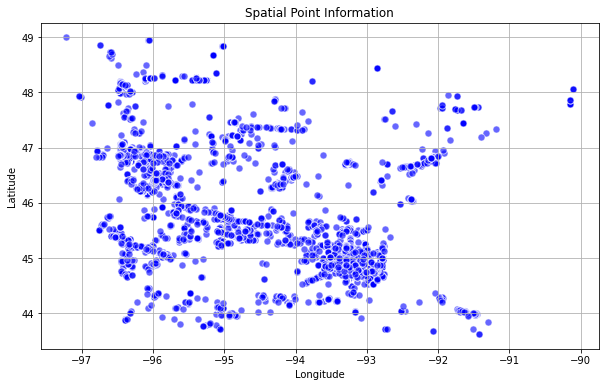

In [18]:

# Read the CSV file into a pandas DataFrame
file_path = '/panfs/jay/groups/31/moeller/shared/leafy-spurge-demography/datasets_oct23/leafy-spurge-csv/eddmaps_inaturalist_spurge_observations_filtered_combined_october2023_minnesota.csv'  # Replace this with the actual path to your CSV file
spurge_df = pd.read_csv(file_path)

# Extract latitude and longitude columns from the DataFrame
latitude = spurge_df['Latitude']  # Replace 'Latitude' with the actual column name in your CSV file
longitude = spurge_df['Longitude']  # Replace 'Longitude' with the actual column name in your CSV file

# Create a scatter plot for latitude and longitude points
plt.figure(figsize=(10, 6))
plt.scatter(longitude, latitude, color='blue', alpha=0.6, edgecolors='w', s=50)  # Adjust size and color as needed
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Spatial Point Information')
plt.grid(True)
plt.show()




In [19]:
# View records
print(spurge_df) #[5298 rows x 4 columns]

           Source    ObsDate   Latitude  Longitude
0         EddMaps  7/28/2010  45.391280 -96.531190
1         EddMaps  7/20/2010  45.386470 -96.534730
2         EddMaps  7/19/2010  45.388100 -96.538190
3         EddMaps  11/4/2010  45.566010 -95.549400
4         EddMaps  11/4/2010  45.564270 -95.548380
...           ...        ...        ...        ...
5293  iNaturalist  6/29/2023  46.709733 -94.187278
5294  iNaturalist  6/30/2023  46.338731 -94.180606
5295  iNaturalist   7/9/2023  44.871125 -93.499337
5296  iNaturalist  7/12/2023  44.970532 -93.288565
5297  iNaturalist  8/28/2023  44.877742 -93.296487

[5298 rows x 4 columns]


# Filter Records for Duplicated Lat/Long Points


In [20]:

# Find and print duplicate records based on latitude and longitude coordinates
duplicate_records = spurge_df[spurge_df.duplicated(subset=['Latitude', 'Longitude'], keep=False)]
print("Duplicate Records based on Latitude and Longitude:")
print(duplicate_records)

# Remove duplicate records from the dataset

# Remove duplicate records based on Latitude and Longitude columns
spurge_df = spurge_df.drop_duplicates(subset=['Latitude', 'Longitude'])

print(spurge_df) #[5091 rows x 4 columns]





Duplicate Records based on Latitude and Longitude:
           Source    ObsDate   Latitude  Longitude
236       EddMaps   7/1/2009  47.054480 -96.418790
283       EddMaps  10/8/2008  47.054480 -96.418790
517       EddMaps  5/31/2005  45.225030 -92.765480
518       EddMaps  5/30/2005  45.225030 -92.765480
519       EddMaps  5/11/2005  45.225030 -92.765480
...           ...        ...        ...        ...
4853  iNaturalist   6/2/2016  45.725010 -94.480300
5208  iNaturalist   6/1/2022  45.020891 -93.509457
5209  iNaturalist   6/6/2022  45.020891 -93.509457
5249  iNaturalist  7/20/2023  45.020891 -93.509457
5250  iNaturalist  7/20/2023  45.020891 -93.509457

[298 rows x 4 columns]
           Source    ObsDate   Latitude  Longitude
0         EddMaps  7/28/2010  45.391280 -96.531190
1         EddMaps  7/20/2010  45.386470 -96.534730
2         EddMaps  7/19/2010  45.388100 -96.538190
3         EddMaps  11/4/2010  45.566010 -95.549400
4         EddMaps  11/4/2010  45.564270 -95.548380
...    

# Summarize Leafy Spurge Records in MN

In [21]:

# Convert 'ObsDate' column to datetime for better handling
spurge_df['ObsDate'] = pd.to_datetime(spurge_df['ObsDate'])

# Extract the source counts
source_counts = spurge_df['Source'].value_counts()

# Extract the year from 'ObsDate' and count observations per year
spurge_df['Year'] = spurge_df['ObsDate'].dt.year
yearly_observation_counts = spurge_df['Year'].value_counts()

print("Source Counts:")
print(source_counts)

# Sort the yearly observation counts by year
yearly_observation_counts = yearly_observation_counts.sort_index()

print("\nYearly Observation Counts:")
print(yearly_observation_counts)

print(spurge_df.head())




Source Counts:
EddMaps        4649
iNaturalist     442
Name: Source, dtype: int64

Yearly Observation Counts:
2000      43
2001      26
2002       6
2003       5
2004     112
2005      48
2006     453
2007      64
2008     218
2009     181
2010     276
2011      93
2012     148
2013      39
2014      35
2015      50
2016     128
2017      94
2018     121
2019     789
2020    1032
2021     533
2022     462
2023     135
Name: Year, dtype: int64
    Source    ObsDate  Latitude  Longitude  Year
0  EddMaps 2010-07-28  45.39128  -96.53119  2010
1  EddMaps 2010-07-20  45.38647  -96.53473  2010
2  EddMaps 2010-07-19  45.38810  -96.53819  2010
3  EddMaps 2010-11-04  45.56601  -95.54940  2010
4  EddMaps 2010-11-04  45.56427  -95.54838  2010


# Distance between points - thinning

<Figure size 720x432 with 0 Axes>

(array([3.078e+03, 3.760e+02, 2.380e+02, 1.830e+02, 1.240e+02, 1.150e+02,
        7.200e+01, 4.900e+01, 4.100e+01, 3.100e+01, 1.700e+01, 1.800e+01,
        1.400e+01, 1.600e+01, 1.200e+01, 1.200e+01, 2.100e+01, 2.100e+01,
        1.900e+01, 1.600e+01, 1.900e+01, 1.300e+01, 1.700e+01, 2.100e+01,
        1.300e+01, 1.600e+01, 1.200e+01, 5.400e+01, 4.500e+01, 1.600e+01,
        2.000e+01, 2.200e+01, 1.300e+01, 1.300e+01, 1.900e+01, 2.300e+01,
        1.100e+01, 1.700e+01, 1.200e+01, 8.000e+00, 1.500e+01, 1.300e+01,
        6.000e+00, 5.000e+00, 1.000e+01, 8.000e+00, 8.000e+00, 7.000e+00,
        3.000e+00, 6.000e+00, 1.700e+01, 6.000e+00, 1.700e+01, 6.000e+00,
        1.200e+01, 6.000e+00, 7.000e+00, 7.000e+00, 6.000e+00, 4.000e+00,
        4.000e+00, 6.000e+00, 7.000e+00, 2.000e+00, 0.000e+00, 2.000e+00,
        2.000e+00, 3.000e+00, 2.000e+00, 6.000e+00, 3.000e+00, 1.000e+00,
        2.000e+00, 1.000e+00, 1.000e+00, 2.000e+00, 2.000e+00, 3.000e+00,
        1.000e+00, 0.000e+00, 1.000e+0

Text(0.5, 0, 'Distance between consecutive points (meters)')

Text(0, 0.5, 'Frequency')

Text(0.5, 1.0, 'Histogram of Distances between Points (0-100 meters)')

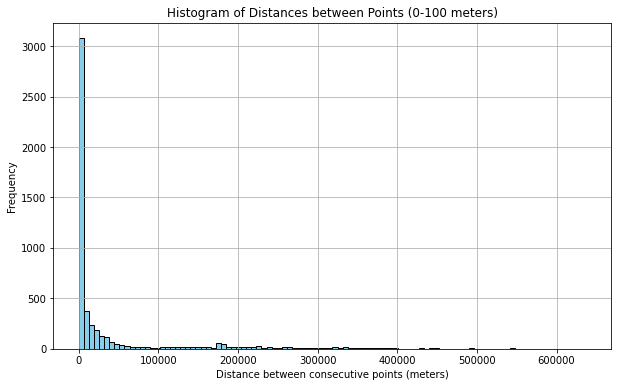

In [22]:

# Calculate distances between consecutive points in the dataset
distances = [geodesic((spurge_df['Latitude'].iloc[i], spurge_df['Longitude'].iloc[i]), 
                      (spurge_df['Latitude'].iloc[i + 1], spurge_df['Longitude'].iloc[i + 1])).meters
             for i in range(len(spurge_df) - 1)]


# Plot a histogram of distances between 0 and 100 meters
plt.figure(figsize=(10, 6))
plt.hist(distances, bins=100, color='skyblue', edgecolor='black')
plt.xlabel('Distance between consecutive points (meters)')
plt.ylabel('Frequency')
plt.title('Histogram of Distances between Points (0-100 meters)')
#plt.xlim(0, 1000)  # Set x-axis limits to zoom in on distances between 0 and 100 meters
plt.grid(True)
plt.show()



# Thin Spurge Occurrences to 100 Meters

In [23]:


# Initialize an empty list to store thinned points
thinned_points = []

# Initialize a variable to keep track of the last retained index
last_retained_index = None

# Iterate through the DataFrame and thin points by 100 meters
for i in range(len(spurge_df)):
    # Always keep the first point
    if last_retained_index is None:
        thinned_points.append(spurge_df.iloc[i])
        last_retained_index = i
    else:
        # Calculate distance between the current point and the last retained point
        distance = geodesic((spurge_df['Latitude'].iloc[i], spurge_df['Longitude'].iloc[i]),
                            (spurge_df['Latitude'].iloc[last_retained_index], 
                             spurge_df['Longitude'].iloc[last_retained_index])).meters
        # Keep the point if it is at least 100 meters away from the last retained point
        if distance >= 100:
            thinned_points.append(spurge_df.iloc[i])
            last_retained_index = i

# Create a new DataFrame for thinned points using pandas.concat
spurge_thinned_df = pd.concat(thinned_points, axis=1).T

# Print the thinned DataFrame
print(spurge_thinned_df)



           Source    ObsDate   Latitude  Longitude  Year
0         EddMaps 2010-07-28   45.39128  -96.53119  2010
1         EddMaps 2010-07-20   45.38647  -96.53473  2010
2         EddMaps 2010-07-19    45.3881  -96.53819  2010
3         EddMaps 2010-11-04   45.56601   -95.5494  2010
4         EddMaps 2010-11-04   45.56427  -95.54838  2010
...           ...        ...        ...        ...   ...
5293  iNaturalist 2023-06-29  46.709733 -94.187278  2023
5294  iNaturalist 2023-06-30  46.338731 -94.180606  2023
5295  iNaturalist 2023-07-09  44.871125 -93.499337  2023
5296  iNaturalist 2023-07-12  44.970532 -93.288565  2023
5297  iNaturalist 2023-08-28  44.877742 -93.296487  2023

[4440 rows x 5 columns]


In [24]:

# Count thinned points by year
source_counts_thinned = spurge_thinned_df['Year'].value_counts().sort_index()

print(source_counts_thinned)

np.sum(source_counts_thinned)



2000     31
2001     26
2002      6
2003      4
2004    107
2005     46
2006    398
2007     60
2008    195
2009    151
2010    186
2011     81
2012    122
2013     38
2014     31
2015     46
2016    117
2017     77
2018    120
2019    641
2020    939
2021    472
2022    413
2023    133
Name: Year, dtype: int64


4440

<Figure size 720x432 with 0 Axes>

Text(0.5, 0, 'Longitude')

Text(0, 0.5, 'Latitude')

Text(0.5, 1.0, 'Spatial Point Information')

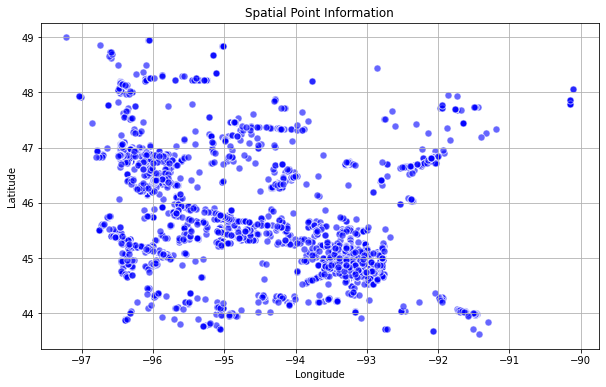

In [25]:

# Extract latitude and longitude columns from the DataFrame
latitude = spurge_thinned_df['Latitude']  # Replace 'Latitude' with the actual column name in your CSV file
longitude = spurge_thinned_df['Longitude']  # Replace 'Longitude' with the actual column name in your CSV file

# Create a scatter plot for latitude and longitude points
plt.figure(figsize=(10, 6))
plt.scatter(longitude, latitude, color='blue', alpha=0.6, edgecolors='w', s=50)  # Adjust size and color as needed
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Spatial Point Information')
plt.grid(True)
plt.show()




# Clip Points to MN Shapefile

EPSG:4326


<AxesSubplot:>

Text(0.5, 15.0, 'Longitude')

Text(99.16655329633359, 0.5, 'Latitude')

Text(0.5, 1.0, 'Thinned Points Overlaying Shapefile')

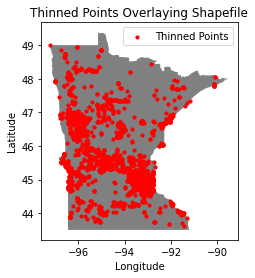

In [26]:

# Read in the shapefile
shapefile_path = '/panfs/jay/groups/31/moeller/shared/leafy-spurge-demography/shapefiles/Minnesota_Shapefile.shp' 
shapefile = gpd.read_file(shapefile_path)

print(shapefile.crs)

# # Plot the shapefile
shapefile.plot(color='gray')

# Plot the thinned points on top of the shapefile
plt.scatter(spurge_thinned_df['Longitude'], spurge_thinned_df['Latitude'], color='red', label='Thinned Points', s=10)

# Customize the plot
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Thinned Points Overlaying Shapefile')
plt.legend()
plt.show()





# Sample Leafy Spurge Occurrences By Year

In [27]:
# Add LandCoverValue of 99 to represent leafy spurge class
spurge_thinned_df['LandCoverValue'] = 99

print(len(spurge_thinned_df))
                   
# Select leafy spurge records from 2000 - 2002
spurge_2000_2001_2002 = spurge_thinned_df[(spurge_thinned_df['Year'] == 2000) | (spurge_thinned_df['Year'] == 2001) | (spurge_thinned_df['Year'] == 2002)]

print(spurge_2000_2001_2002.shape)


# Select leafy spurge records from 2003_2004_2005
spurge_2003_2004_2005 = spurge_thinned_df[(spurge_thinned_df['Year'] == 2003) | (spurge_thinned_df['Year'] == 2004) | (spurge_thinned_df['Year'] == 2005)]

print(spurge_2003_2004_2005.shape)


# Select leafy spurge records from 2006_2007_2008
spurge_2006_2007_2008 = spurge_thinned_df[(spurge_thinned_df['Year'] == 2006) | (spurge_thinned_df['Year'] == 2007) | (spurge_thinned_df['Year'] == 2008)]

print(spurge_2006_2007_2008.shape)


# Select leafy spurge records from 2009_2010_2011
spurge_2009_2010_2011 = spurge_thinned_df[(spurge_thinned_df['Year'] == 2009) | (spurge_thinned_df['Year'] == 2010) | (spurge_thinned_df['Year'] == 2011)]

print(spurge_2009_2010_2011.shape)


# Select leafy spurge records from 2013_2014_2015
spurge_2013_2014_2015 = spurge_thinned_df[(spurge_thinned_df['Year'] == 2013) | (spurge_thinned_df['Year'] == 2014) | (spurge_thinned_df['Year'] == 2015)]

print(spurge_2013_2014_2015.shape)


# Select leafy spurge records from 2015_2016_2017
spurge_2015_2016_2017 = spurge_thinned_df[(spurge_thinned_df['Year'] == 2015) | (spurge_thinned_df['Year'] == 2016) | (spurge_thinned_df['Year'] == 2017)]

print(spurge_2015_2016_2017.shape)


# Select leafy spurge records from 2018_2019_2020
spurge_2018_2019_2020 = spurge_thinned_df[(spurge_thinned_df['Year'] == 2018) | (spurge_thinned_df['Year'] == 2019) | (spurge_thinned_df['Year'] == 2020)]

print(spurge_2018_2019_2020.shape)


# Select leafy spurge records after 2020 for validation

spurge_2021_2022_2023 = spurge_thinned_df[(spurge_thinned_df['Year'] == 2021) | (spurge_thinned_df['Year'] == 2022) | (spurge_thinned_df['Year'] == 2023)]

print(spurge_2021_2022_2023.shape)



4440
(63, 6)
(157, 6)
(653, 6)
(418, 6)
(115, 6)
(240, 6)
(1700, 6)
(1018, 6)


# Generate random land cover background points

In [28]:

# Read in the shapefile
shapefile_path = '/panfs/jay/groups/31/moeller/shared/leafy-spurge-demography/shapefiles/Minnesota_Shapefile.shp' 
shapefile = gpd.read_file(shapefile_path)


# Generate 10,000 random points within the boundaries of the shapefile
random_points = []
for i in range(100000):
    while True:
        # Generate random latitude and longitude within the shapefile bounds
        latitude = random.uniform(shapefile.bounds.miny.values[0], shapefile.bounds.maxy.values[0])
        longitude = random.uniform(shapefile.bounds.minx.values[0], shapefile.bounds.maxx.values[0])
        
        # Create a Point object
        point = Point(longitude, latitude)
        
        # Check if the point is within the shapefile
        if shapefile.geometry.contains(point).any():
            break

    # Format the attributes and append to random_points list
    random_point_attributes = {
        'Source': 'Land Cover',
        'ObsDate': datetime(year=2019, month=random.randint(1, 12), day=random.randint(1, 28)),  # Random date in 2019
        'Latitude': latitude,
        'Longitude': longitude,
        'Year': 2019
    }
    random_points.append(random_point_attributes)
    
    # Print progress every 1000 points
    if i % 10000 == 0 and i != 0:
        print(f'Generated {i} points...')

# Create a DataFrame from random_points
random_df = pd.DataFrame(random_points)

# Print the DataFrame
print(random_df)


Generated 10000 points...
Generated 20000 points...
Generated 30000 points...
Generated 40000 points...
Generated 50000 points...
Generated 60000 points...
Generated 70000 points...
Generated 80000 points...
Generated 90000 points...
           Source    ObsDate   Latitude  Longitude  Year
0      Land Cover 2019-12-07  43.789050 -93.032722  2019
1      Land Cover 2019-02-13  46.675708 -93.003881  2019
2      Land Cover 2019-08-06  48.454574 -93.642958  2019
3      Land Cover 2019-09-16  45.284481 -95.874988  2019
4      Land Cover 2019-10-01  46.862366 -94.530952  2019
...           ...        ...        ...        ...   ...
99995  Land Cover 2019-10-12  45.995616 -93.585173  2019
99996  Land Cover 2019-11-25  44.994734 -94.834365  2019
99997  Land Cover 2019-09-26  46.662085 -96.669816  2019
99998  Land Cover 2019-06-22  48.210360 -92.649261  2019
99999  Land Cover 2019-02-21  48.437364 -92.849478  2019

[100000 rows x 5 columns]


# Thin random land cover background points to 100 meters

In [29]:
# Thin random background points to 100 meters

# Initialize an empty list to store thinned points
thinned_background_points = []

# Initialize a variable to keep track of the last retained index
last_retained_index = None

# Iterate through the DataFrame and thin points by 100 meters
for i in range(len(random_df)):
    # Always keep the first point
    if last_retained_index is None:
        thinned_background_points.append(random_df.iloc[i])
        last_retained_index = i
    else:
        # Calculate distance between the current point and the last retained point
        distance = geodesic((random_df['Latitude'].iloc[i], random_df['Longitude'].iloc[i]),
                            (random_df['Latitude'].iloc[last_retained_index], 
                             random_df['Longitude'].iloc[last_retained_index])).meters
        # Keep the point if it is at least 100 meters away from the last retained point
        if distance >= 100:
            thinned_background_points.append(random_df.iloc[i])
            last_retained_index = i

# Create a new DataFrame for thinned points using pandas.concat
land_cover_df = pd.concat(thinned_background_points, axis=1).T

# Print the thinned DataFrame
print(land_cover_df)



           Source    ObsDate   Latitude  Longitude  Year
0      Land Cover 2019-12-07   43.78905 -93.032722  2019
1      Land Cover 2019-02-13  46.675708 -93.003881  2019
2      Land Cover 2019-08-06  48.454574 -93.642958  2019
3      Land Cover 2019-09-16  45.284481 -95.874988  2019
4      Land Cover 2019-10-01  46.862366 -94.530952  2019
...           ...        ...        ...        ...   ...
99995  Land Cover 2019-10-12  45.995616 -93.585173  2019
99996  Land Cover 2019-11-25  44.994734 -94.834365  2019
99997  Land Cover 2019-09-26  46.662085 -96.669816  2019
99998  Land Cover 2019-06-22   48.21036 -92.649261  2019
99999  Land Cover 2019-02-21  48.437364 -92.849478  2019

[100000 rows x 5 columns]


<AxesSubplot:>

Text(0.5, 15.0, 'Longitude')

Text(99.16655329633359, 0.5, 'Latitude')

Text(0.5, 1.0, 'Land Cover Points Overlaying Shapefile')

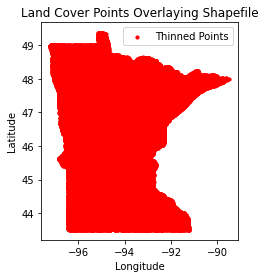

In [30]:
# Plot Random Background Land Cover Points

# # Plot the shapefile
shapefile.plot(color='gray')

# Plot the thinned points on top of the shapefile
plt.scatter(land_cover_df['Longitude'], land_cover_df['Latitude'], color='red', label='Thinned Points', s=10)

# Customize the plot
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Land Cover Points Overlaying Shapefile')
plt.legend()
plt.show()


# Build Eight Land Cover Datasets (2019 - 2001) For Land Cover Samples

In [31]:

# Create a new dataframe for Year 2019
land_cover_2019_df = land_cover_df.copy()

# Create a new dataframe for Year 2016
land_cover_2016_df = land_cover_df.copy()
land_cover_2016_df['Year'] = 2016

# Create a new dataframe for Year 2014
land_cover_2014_df = land_cover_df.copy()
land_cover_2014_df['Year'] = 2014

# Create a new dataframe for Year 2010
land_cover_2010_df = land_cover_df.copy()
land_cover_2010_df['Year'] = 2010

# Create a new dataframe for Year 2007
land_cover_2007_df = land_cover_df.copy()
land_cover_2007_df['Year'] = 2007

# Create a new dataframe for Year 2004
land_cover_2004_df = land_cover_df.copy()
land_cover_2004_df['Year'] = 2004

# Create a new dataframe for Year 2001
land_cover_2001_df = land_cover_df.copy()
land_cover_2001_df['Year'] = 2001


# Sample NLCD from Sampled Land Cover points

In [32]:

### 2019 ###

# Open the raster file
raster_path = '/panfs/jay/groups/31/moeller/shared/leafy-spurge-demography/NLCD_land_cover_minnesota/nlcd_2019_land_cover_minnesota.tif'  # Replace this with the actual path to your raster file

# Open the raster file
with rasterio.open(raster_path) as src:
    # Read the raster data as a NumPy array
    raster_array = src.read(1)  # Assuming a single band raster, change the index if you have multiple bands
    
    # Get the affine transform of the raster
    transform = src.transform
    
    # Sample raster values at points in random_df
    sampled_values = []
    for index, row in land_cover_df.iterrows():
        # Convert latitude and longitude to pixel coordinates in the raster
        lon, lat = row['Longitude'], row['Latitude']
        col, row = ~transform * (lon, lat)  # ~transform inverts the transform (from pixel to geographic coordinates)
        
        # Ensure the point is within the raster bounds
        if 0 <= row < src.height and 0 <= col < src.width:
            # Sample the raster value at the point
            raster_value = raster_array[int(row), int(col)]
            sampled_values.append(raster_value)
        else:
            sampled_values.append(None)  # Set None for points outside raster bounds

# Add sampled values to the random_df DataFrame
land_cover_2019_df['LandCoverValue'] = sampled_values

# Print the updated DataFrame with raster values
print(land_cover_2019_df)




### 2016 ###

# Open the raster file
raster_path = '/panfs/jay/groups/31/moeller/shared/leafy-spurge-demography/NLCD_land_cover_minnesota/nlcd_2016_land_cover_minnesota.tif'  # Replace this with the actual path to your raster file

# Open the raster file
with rasterio.open(raster_path) as src:
    # Read the raster data as a NumPy array
    raster_array = src.read(1)  # Assuming a single band raster, change the index if you have multiple bands
    
    # Get the affine transform of the raster
    transform = src.transform
    
    # Sample raster values at points in random_df
    sampled_values = []
    for index, row in land_cover_df.iterrows():
        # Convert latitude and longitude to pixel coordinates in the raster
        lon, lat = row['Longitude'], row['Latitude']
        col, row = ~transform * (lon, lat)  # ~transform inverts the transform (from pixel to geographic coordinates)
        
        # Ensure the point is within the raster bounds
        if 0 <= row < src.height and 0 <= col < src.width:
            # Sample the raster value at the point
            raster_value = raster_array[int(row), int(col)]
            sampled_values.append(raster_value)
        else:
            sampled_values.append(None)  # Set None for points outside raster bounds

# Add sampled values to the random_df DataFrame
land_cover_2016_df['LandCoverValue'] = sampled_values

# Print the updated DataFrame with raster values
print(land_cover_2016_df)





### 2014 ###

# Open the raster file
raster_path = '/panfs/jay/groups/31/moeller/shared/leafy-spurge-demography/NLCD_land_cover_minnesota/nlcd_2013_land_cover_minnesota.tif'  # Replace this with the actual path to your raster file

# Open the raster file
with rasterio.open(raster_path) as src:
    # Read the raster data as a NumPy array
    raster_array = src.read(1)  # Assuming a single band raster, change the index if you have multiple bands
    
    # Get the affine transform of the raster
    transform = src.transform
    
    # Sample raster values at points in random_df
    sampled_values = []
    for index, row in land_cover_df.iterrows():
        # Convert latitude and longitude to pixel coordinates in the raster
        lon, lat = row['Longitude'], row['Latitude']
        col, row = ~transform * (lon, lat)  # ~transform inverts the transform (from pixel to geographic coordinates)
        
        # Ensure the point is within the raster bounds
        if 0 <= row < src.height and 0 <= col < src.width:
            # Sample the raster value at the point
            raster_value = raster_array[int(row), int(col)]
            sampled_values.append(raster_value)
        else:
            sampled_values.append(None)  # Set None for points outside raster bounds

# Add sampled values to the random_df DataFrame
land_cover_2014_df['LandCoverValue'] = sampled_values

# Print the updated DataFrame with raster values
print(land_cover_2014_df)





### 2010 ###

# Open the raster file
raster_path = '/panfs/jay/groups/31/moeller/shared/leafy-spurge-demography/NLCD_land_cover_minnesota/nlcd_2011_land_cover_minnesota.tif'  # Replace this with the actual path to your raster file

# Open the raster file
with rasterio.open(raster_path) as src:
    # Read the raster data as a NumPy array
    raster_array = src.read(1)  # Assuming a single band raster, change the index if you have multiple bands
    
    # Get the affine transform of the raster
    transform = src.transform
    
    # Sample raster values at points in random_df
    sampled_values = []
    for index, row in land_cover_df.iterrows():
        # Convert latitude and longitude to pixel coordinates in the raster
        lon, lat = row['Longitude'], row['Latitude']
        col, row = ~transform * (lon, lat)  # ~transform inverts the transform (from pixel to geographic coordinates)
        
        # Ensure the point is within the raster bounds
        if 0 <= row < src.height and 0 <= col < src.width:
            # Sample the raster value at the point
            raster_value = raster_array[int(row), int(col)]
            sampled_values.append(raster_value)
        else:
            sampled_values.append(None)  # Set None for points outside raster bounds

# Add sampled values to the random_df DataFrame
land_cover_2010_df['LandCoverValue'] = sampled_values

# Print the updated DataFrame with raster values
print(land_cover_2010_df)





### 2007 ###

# Open the raster file
raster_path = '/panfs/jay/groups/31/moeller/shared/leafy-spurge-demography/NLCD_land_cover_minnesota/nlcd_2008_land_cover_minnesota.tif'  # Replace this with the actual path to your raster file

# Open the raster file
with rasterio.open(raster_path) as src:
    # Read the raster data as a NumPy array
    raster_array = src.read(1)  # Assuming a single band raster, change the index if you have multiple bands
    
    # Get the affine transform of the raster
    transform = src.transform
    
    # Sample raster values at points in random_df
    sampled_values = []
    for index, row in land_cover_df.iterrows():
        # Convert latitude and longitude to pixel coordinates in the raster
        lon, lat = row['Longitude'], row['Latitude']
        col, row = ~transform * (lon, lat)  # ~transform inverts the transform (from pixel to geographic coordinates)
        
        # Ensure the point is within the raster bounds
        if 0 <= row < src.height and 0 <= col < src.width:
            # Sample the raster value at the point
            raster_value = raster_array[int(row), int(col)]
            sampled_values.append(raster_value)
        else:
            sampled_values.append(None)  # Set None for points outside raster bounds

# Add sampled values to the random_df DataFrame
land_cover_2007_df['LandCoverValue'] = sampled_values

# Print the updated DataFrame with raster values
print(land_cover_2007_df)





### 2004 ###

# Open the raster file
raster_path = '/panfs/jay/groups/31/moeller/shared/leafy-spurge-demography/NLCD_land_cover_minnesota/nlcd_2004_land_cover_minnesota.tif'  # Replace this with the actual path to your raster file

# Open the raster file
with rasterio.open(raster_path) as src:
    # Read the raster data as a NumPy array
    raster_array = src.read(1)  # Assuming a single band raster, change the index if you have multiple bands
    
    # Get the affine transform of the raster
    transform = src.transform
    
    # Sample raster values at points in random_df
    sampled_values = []
    for index, row in land_cover_df.iterrows():
        # Convert latitude and longitude to pixel coordinates in the raster
        lon, lat = row['Longitude'], row['Latitude']
        col, row = ~transform * (lon, lat)  # ~transform inverts the transform (from pixel to geographic coordinates)
        
        # Ensure the point is within the raster bounds
        if 0 <= row < src.height and 0 <= col < src.width:
            # Sample the raster value at the point
            raster_value = raster_array[int(row), int(col)]
            sampled_values.append(raster_value)
        else:
            sampled_values.append(None)  # Set None for points outside raster bounds

# Add sampled values to the random_df DataFrame
land_cover_2004_df['LandCoverValue'] = sampled_values

# Print the updated DataFrame with raster values
print(land_cover_2004_df)






### 2001 ###

# Open the raster file
raster_path = '/panfs/jay/groups/31/moeller/shared/leafy-spurge-demography/NLCD_land_cover_minnesota/nlcd_2001_land_cover_minnesota.tif'  # Replace this with the actual path to your raster file

# Open the raster file
with rasterio.open(raster_path) as src:
    # Read the raster data as a NumPy array
    raster_array = src.read(1)  # Assuming a single band raster, change the index if you have multiple bands
    
    # Get the affine transform of the raster
    transform = src.transform
    
    # Sample raster values at points in random_df
    sampled_values = []
    for index, row in land_cover_df.iterrows():
        # Convert latitude and longitude to pixel coordinates in the raster
        lon, lat = row['Longitude'], row['Latitude']
        col, row = ~transform * (lon, lat)  # ~transform inverts the transform (from pixel to geographic coordinates)
        
        # Ensure the point is within the raster bounds
        if 0 <= row < src.height and 0 <= col < src.width:
            # Sample the raster value at the point
            raster_value = raster_array[int(row), int(col)]
            sampled_values.append(raster_value)
        else:
            sampled_values.append(None)  # Set None for points outside raster bounds

# Add sampled values to the random_df DataFrame
land_cover_2001_df['LandCoverValue'] = sampled_values

# Print the updated DataFrame with raster values
print(land_cover_2001_df)



           Source    ObsDate   Latitude  Longitude  Year  LandCoverValue
0      Land Cover 2019-12-07   43.78905 -93.032722  2019              82
1      Land Cover 2019-02-13  46.675708 -93.003881  2019              81
2      Land Cover 2019-08-06  48.454574 -93.642958  2019              90
3      Land Cover 2019-09-16  45.284481 -95.874988  2019              82
4      Land Cover 2019-10-01  46.862366 -94.530952  2019              90
...           ...        ...        ...        ...   ...             ...
99995  Land Cover 2019-10-12  45.995616 -93.585173  2019              95
99996  Land Cover 2019-11-25  44.994734 -94.834365  2019              82
99997  Land Cover 2019-09-26  46.662085 -96.669816  2019              82
99998  Land Cover 2019-06-22   48.21036 -92.649261  2019              43
99999  Land Cover 2019-02-21  48.437364 -92.849478  2019              11

[100000 rows x 6 columns]
           Source    ObsDate   Latitude  Longitude  Year  LandCoverValue
0      Land Cover 2019-1

In [33]:
# Remove instances of land cover classes: 0 or -1 that falls outside of MN polygon

land_cover_2019_df = land_cover_2019_df[land_cover_2019_df.LandCoverValue != 0]
land_cover_2019_df = land_cover_2019_df[land_cover_2019_df.LandCoverValue != -1]

land_cover_2016_df = land_cover_2016_df[land_cover_2016_df.LandCoverValue != 0]
land_cover_2016_df = land_cover_2016_df[land_cover_2016_df.LandCoverValue != -1]

land_cover_2014_df = land_cover_2014_df[land_cover_2014_df.LandCoverValue != 0]
land_cover_2014_df = land_cover_2014_df[land_cover_2014_df.LandCoverValue != -1]

land_cover_2010_df = land_cover_2010_df[land_cover_2010_df.LandCoverValue != 0]
land_cover_2010_df = land_cover_2010_df[land_cover_2010_df.LandCoverValue != -1]

land_cover_2007_df = land_cover_2007_df[land_cover_2007_df.LandCoverValue != 0]
land_cover_2007_df = land_cover_2007_df[land_cover_2007_df.LandCoverValue != -1]

land_cover_2004_df = land_cover_2004_df[land_cover_2004_df.LandCoverValue != 0]
land_cover_2004_df = land_cover_2004_df[land_cover_2004_df.LandCoverValue != -1]

land_cover_2001_df = land_cover_2001_df[land_cover_2001_df.LandCoverValue != 0]
land_cover_2001_df = land_cover_2001_df[land_cover_2001_df.LandCoverValue != -1]



# Count number of sampled NLCD Classes/ Year

In [34]:

# Extract the source counts
landcover_counts = land_cover_2019_df['LandCoverValue'].value_counts().sort_index()

print("Land Cover Counts:")
print(landcover_counts)

# Extract the source counts
landcover_counts = land_cover_2016_df['LandCoverValue'].value_counts().sort_index()

print("Land Cover Counts:")
print(landcover_counts)

# Extract the source counts
landcover_counts = land_cover_2014_df['LandCoverValue'].value_counts().sort_index()

print("Land Cover Counts:")
print(landcover_counts)

# Extract the source counts
landcover_counts = land_cover_2010_df['LandCoverValue'].value_counts().sort_index()

print("Land Cover Counts:")
print(landcover_counts)

# Extract the source counts
landcover_counts = land_cover_2007_df['LandCoverValue'].value_counts().sort_index()

print("Land Cover Counts:")
print(landcover_counts)

# Extract the source counts
landcover_counts = land_cover_2004_df['LandCoverValue'].value_counts().sort_index()

print("Land Cover Counts:")
print(landcover_counts)

# Extract the source counts
landcover_counts = land_cover_2001_df['LandCoverValue'].value_counts().sort_index()

print("Land Cover Counts:")
print(landcover_counts)




Land Cover Counts:
11     5809
21     2691
22     1639
23      952
24      304
31      178
41    11517
42     2143
43     4812
52      831
71     1077
81     5702
82    38276
90    16049
95     8016
Name: LandCoverValue, dtype: int64
Land Cover Counts:
11     5889
21     2741
22     1632
23      896
24      296
31      183
41    11100
42     2149
43     4766
52     1123
71     1245
81     5703
82    38242
90    16012
95     8019
Name: LandCoverValue, dtype: int64
Land Cover Counts:
11     5918
21     2772
22     1624
23      851
24      281
31      181
41    11252
42     2184
43     4773
52      960
71     1230
81     5812
82    38207
90    15903
95     8048
Name: LandCoverValue, dtype: int64
Land Cover Counts:
11     5965
21     2801
22     1623
23      821
24      272
31      180
41    11230
42     2227
43     4770
52      774
71     1404
81     5863
82    38211
90    15519
95     8336
Name: LandCoverValue, dtype: int64
Land Cover Counts:
11     5925
21     2779
22     1610
23      7

# Merge Leafy Spurge Points to Land Cover Class



In [ ]:

# Concatenate data for the 2018-2019-2020 period
dfs_2019 = [spurge_2018_2019_2020, land_cover_2019_df]

spurge_landcover_2019 = pd.concat(dfs_2019).drop(columns=['ObsDate'])

spurge_landcover_2019 

# Concatenate data for the 2015-2016-2017 period
dfs_2016 = [spurge_2015_2016_2017, land_cover_2016_df]

spurge_landcover_2016 = pd.concat(dfs_2016).drop(columns=['ObsDate'])

spurge_landcover_2016

# Concatenate data for the 2013-2014-2015 period
dfs_2014 = [spurge_2013_2014_2015, land_cover_2014_df]

spurge_landcover_2014 = pd.concat(dfs_2014).drop(columns=['ObsDate'])

spurge_landcover_2014

# Concatenate data for the 2009-2010-2011 period
dfs_2010 = [spurge_2009_2010_2011, land_cover_2010_df]

spurge_landcover_2010 = pd.concat(dfs_2010).drop(columns=['ObsDate'])

spurge_landcover_2010

# Concatenate data for the 2006-2007-2008 period
dfs_2007 = [spurge_2006_2007_2008, land_cover_2007_df]

spurge_landcover_2007 = pd.concat(dfs_2007).drop(columns=['ObsDate'])

spurge_landcover_2007

# Concatenate data for the 2003-2004-2005 period
dfs_2004 = [spurge_2003_2004_2005, land_cover_2004_df]

spurge_landcover_2004 = pd.concat(dfs_2004).drop(columns=['ObsDate'])

spurge_landcover_2004

# Concatenate data for the 2000-2001-2002 period
dfs_2001 = [spurge_2000_2001_2002, land_cover_2001_df]

spurge_landcover_2001 = pd.concat(dfs_2001).drop(columns=['ObsDate'])

spurge_landcover_2001



# Save Landcover/ Leafy Spurge Class Locations & Sampling Years

In [ ]:
# Save dataframes with leafy spurge and land cover locations (no landsat spectral information)

spurge_landcover_2019.to_csv(r'/panfs/jay/groups/31/moeller/shared/leafy-spurge-demography/datasets_oct23/landcover-leafyspurge-mn-samples/spurge_landcover_2019_100ksample_locations_nolandsat.csv')

spurge_landcover_2016.to_csv(r'/panfs/jay/groups/31/moeller/shared/leafy-spurge-demography/datasets_oct23/landcover-leafyspurge-mn-samples/spurge_landcover_2016_100ksample_locations_nolandsat.csv')

spurge_landcover_2014.to_csv(r'/panfs/jay/groups/31/moeller/shared/leafy-spurge-demography/datasets_oct23/landcover-leafyspurge-mn-samples/spurge_landcover_2014_100ksample_locations_nolandsat.csv')

spurge_landcover_2010.to_csv(r'/panfs/jay/groups/31/moeller/shared/leafy-spurge-demography/datasets_oct23/landcover-leafyspurge-mn-samples/spurge_landcover_2010_100ksample_locations_nolandsat.csv')

spurge_landcover_2007.to_csv(r'/panfs/jay/groups/31/moeller/shared/leafy-spurge-demography/datasets_oct23/landcover-leafyspurge-mn-samples/spurge_landcover_2007_100ksample_locations_nolandsat.csv')

spurge_landcover_2004.to_csv(r'/panfs/jay/groups/31/moeller/shared/leafy-spurge-demography/datasets_oct23/landcover-leafyspurge-mn-samples/spurge_landcover_2004_100ksample_locations_nolandsat.csv')

spurge_landcover_2001.to_csv(r'/panfs/jay/groups/31/moeller/shared/leafy-spurge-demography/datasets_oct23/landcover-leafyspurge-mn-samples/spurge_landcover_2001_100ksample_locations_nolandsat.csv')




# With Leafy Spurge and Land Cover Data - Sample Landsat Satellite Imagery

In [1]:
import pandas as pd
import rasterio

# Set variables
year = 2019
tile_idx = 287

# Read in .csv file - containing Source (EddMaps, LandCover), Latitude, Longitude, Year, and Land Cover Class Values
csv_path = f'/panfs/jay/groups/31/moeller/shared/leafy-spurge-demography/datasets_oct23/landcover-leafyspurge-mn-samples/spurge_landcover_{year}_100ksample_locations_nolandsat.csv'

spurge_landcover_locs = pd.read_csv(csv_path, index_col=0)

# Reset dataframe index to start from 1
spurge_landcover_locs.reset_index(drop=True, inplace=True)


In [2]:

# Open the Landsat three-year raster file
raster_path = f'/panfs/jay/groups/31/moeller/shared/leafy-spurge-demography/minnesota_landsat_tiles/tile_{tile_idx}/landsat_image_temporalcnn_{year}_tile_{tile_idx}_.tif'

# Open the raster file
with rasterio.open(raster_path) as src:
    
    raster_array = src.read()  # Assuming a single band raster, change the index if you have multiple bands
    
    # Get the affine transform of the raster
    transform = src.transform
    

In [3]:
# Define the 63 raster bands in Landsat image

BANDS = ['0_BlueMarchApril',
 '0_GreenMarchApril',
 '0_RedMarchApril',
 '0_NIRMarchApril',
 '0_SWIR1MarchApril',
 '0_SWIR2MarchApril',
 '0_NDVIMarchApril',
 '0_BlueMayJune',
 '0_GreenMayJune',
 '0_RedMayJune',
 '0_NIRMayJune',
 '0_SWIR1MayJune',
 '0_SWIR2MayJune',
 '0_NDVIMayJune',
 '0_BlueJulyAug',
 '0_GreenJulyAug',
 '0_RedJulyAug',
 '0_NIRJulyAug',
 '0_SWIR1JulyAug',
 '0_SWIR2JulyAug',
 '0_NDVIJulyAug',
 '1_BlueMarchApril',
 '1_GreenMarchApril',
 '1_RedMarchApril',
 '1_NIRMarchApril',
 '1_SWIR1MarchApril',
 '1_SWIR2MarchApril',
 '1_NDVIMarchApril',
 '1_BlueMayJune',
 '1_GreenMayJune',
 '1_RedMayJune',
 '1_NIRMayJune',
 '1_SWIR1MayJune',
 '1_SWIR2MayJune',
 '1_NDVIMayJune',
 '1_BlueJulyAug',
 '1_GreenJulyAug',
 '1_RedJulyAug',
 '1_NIRJulyAug',
 '1_SWIR1JulyAug',
 '1_SWIR2JulyAug',
 '1_NDVIJulyAug',
 '2_BlueMarchApril',
 '2_GreenMarchApril',
 '2_RedMarchApril',
 '2_NIRMarchApril',
 '2_SWIR1MarchApril',
 '2_SWIR2MarchApril',
 '2_NDVIMarchApril',
 '2_BlueMayJune',
 '2_GreenMayJune',
 '2_RedMayJune',
 '2_NIRMayJune',
 '2_SWIR1MayJune',
 '2_SWIR2MayJune',
 '2_NDVIMayJune',
 '2_BlueJulyAug',
 '2_GreenJulyAug',
 '2_RedJulyAug',
 '2_NIRJulyAug',
 '2_SWIR1JulyAug',
 '2_SWIR2JulyAug',
 '2_NDVIJulyAug']



# Sample Landsat satellite raster values at land cover and leafy spurge points


In [4]:
# Sample Landsat raster values at land cover and leafy spurge points

sampled_values = [] #spectral values sampled from Landsat image src
for index, row in spurge_landcover_locs.iterrows():
    # Convert latitude and longitude to pixel coordinates in the raster
    lon, lat = row['Longitude'], row['Latitude']
    col, row = ~transform * (lon, lat)  # ~transform inverts the transform (from pixel to geographic coordinates)

    # Ensure the point is within the raster bounds
    if 0 <= row < src.height and 0 <= col < src.width:
        # Sample the raster value at the point
        raster_value = raster_array[:, int(row), int(col)]
        sampled_values.append(raster_value)
    else:
        sampled_values.append([None] * len(BANDS)) #if point doesn't fall on raster, use None/NaN values
        
# Add sampled land cover and leafy spurge 
landsat_df = pd.DataFrame(sampled_values, columns=BANDS)

# Reset index of both dataframes before merging to ensure correct index values
landsat_df.reset_index(drop=True, inplace=True)

# Merge Landcover, Spurge Locations + Landsat Spectral Bands

In [7]:
# Merge landcover, leafy spurge location data with landsat spectral band information, drop any NA data (outside of Landsat tile)
spurge_landcover_landsat = pd.concat([spurge_landcover_locs, landsat_df], axis=1).dropna()

# Print head of data
spurge_landcover_landsat


,Source,Latitude,Longitude,Year,LandCoverValue,0_BlueMarchApril,0_GreenMarchApril,0_RedMarchApril,0_NIRMarchApril,0_SWIR1MarchApril,...,2_SWIR1MayJune,2_SWIR2MayJune,2_NDVIMayJune,2_BlueJulyAug,2_GreenJulyAug,2_RedJulyAug,2_NIRJulyAug,2_SWIR1JulyAug,2_SWIR2JulyAug,2_NDVIJulyAug
349,EddMaps,47.867450,-94.286860,2019,99,1405.0,1415.0,1540.0,1933.0,1269.0,...,2446.0,1416.0,5828.0,225.0,462.0,350.0,2645.0,1291.0,673.0,7611.0
421,EddMaps,47.869920,-94.285800,2019,99,2574.0,2844.0,3146.0,3506.0,2061.0,...,2691.0,1686.0,5079.0,196.0,430.0,365.0,2361.0,1195.0,661.0,7468.0
458,EddMaps,47.210420,-94.947910,2020,99,611.0,884.0,1147.0,1936.0,2287.0,...,2599.0,1553.0,6199.0,434.0,876.0,832.0,3632.0,2540.0,1438.0,6294.0
459,EddMaps,47.231800,-94.891370,2020,99,599.0,958.0,1256.0,1979.0,2641.0,...,2630.0,1641.0,6456.0,440.0,792.0,719.0,3898.0,2290.0,1313.0,6887.0
460,EddMaps,47.232120,-94.892630,2020,99,639.0,933.0,1124.0,2025.0,2258.0,...,2162.0,1326.0,5907.0,418.0,823.0,713.0,3631.0,2200.0,1298.0,6823.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101458,Land Cover,46.936629,-94.212119,2019,41,813.0,947.0,1201.0,1924.0,2800.0,...,1975.0,844.0,8760.0,252.0,555.0,322.0,4981.0,2082.0,792.0,8667.0
101638,Land Cover,47.248133,-94.888288,2019,90,489.0,747.0,1052.0,1864.0,2460.0,...,2250.0,1180.0,6914.0,227.0,488.0,269.0,4116.0,1972.0,777.0,8666.0
101646,Land Cover,47.178651,-94.517638,2019,11,0.0,0.0,0.0,0.0,0.0,...,389.0,330.0,-408.0,213.0,412.0,164.0,122.0,112.0,105.0,-1249.0
101650,Land Cover,47.573665,-94.079838,2019,42,0.0,0.0,0.0,0.0,0.0,...,1119.0,468.0,8655.0,173.0,355.0,205.0,2608.0,1011.0,449.0,8560.0


# Export single sampled Land Cover, Location, Class, and Spectral Data to CSV

Alternatively, run a Slurm Array to Export All Years and Tiles


In [8]:

#spurge_landcover_landsat.to_csv(f'/panfs/jay/groups/31/moeller/shared/leafy-spurge-demography/datasets_oct23/landcover-leafyspurge-landsat-tiles/{year}_tiles/spurge_landcover_landsat_{year}_100ksample_locations_tile{tile_idx}.csv')


In [32]:
# Combine CSV files across all tiles and within each year into one dataset


# Set variables
years = [2001]
tiles = [251,263,275,287,299,304,316,328,340,351,247,252,264,276,288,300,312,317,329,341,352,248,260,265,277,289,301,313,325,330,342,249,261,273,278,290,302,314,326,338,343,250,262,274,286,291,303,315,327,339,344]

all_df = []
for year in years:
    print(year)
    for tile in tiles:
        data_path = f'/panfs/jay/groups/31/moeller/shared/leafy-spurge-demography/datasets_oct23/landcover-leafyspurge-landsat-tiles/{year}_tiles/spurge_landcover_landsat_{year}_100ksample_locations_tile{tile}.csv'
        df = pd.read_csv(data_path, index_col=0)
        print(df.shape)
        all_df.append(df)

all_df_frame = pd.concat(all_df, axis=0)    

all_df_frame.to_csv(f'/panfs/jay/groups/31/moeller/shared/leafy-spurge-demography/datasets_oct23/spurge_landcover_landsat_spectral_2001_100ksample_locations_MN.csv')


2001
(0, 68)
(2496, 68)
(3808, 68)
(3941, 68)
(2667, 68)
(1588, 68)
(2770, 68)
(0, 68)
(0, 68)
(134, 68)
(583, 68)
(0, 68)
(1887, 68)
(3921, 68)
(4038, 68)
(3895, 68)
(2071, 68)
(1657, 68)
(455, 68)
(0, 68)
(24, 68)
(8, 68)
(3895, 68)
(758, 68)
(3939, 68)
(3985, 68)
(3980, 68)
(3901, 68)
(903, 68)
(1051, 68)
(0, 68)
(0, 68)
(3620, 68)
(3968, 68)
(1503, 68)
(3894, 68)
(3831, 68)
(2699, 68)
(2931, 68)
(821, 68)
(0, 68)
(0, 68)
(2774, 68)
(3864, 68)
(3353, 68)
(1618, 68)
(3817, 68)
(813, 68)
(11, 68)
(856, 68)
(0, 68)


,Source,Latitude,Longitude,Year,LandCoverValue,0_BlueMarchApril,0_GreenMarchApril,0_RedMarchApril,0_NIRMarchApril,0_SWIR1MarchApril,...,2_SWIR1MayJune,2_SWIR2MayJune,2_NDVIMayJune,2_BlueJulyAug,2_GreenJulyAug,2_RedJulyAug,2_NIRJulyAug,2_SWIR1JulyAug,2_SWIR2JulyAug,2_NDVIJulyAug
40,EddMaps,45.09622,-96.42967,2019,99,685.0,910.0,1084.0,1530.0,2985.0,...,3702.0,3071.0,2432.0,339.0,541.0,404.0,3921.0,1990.0,960.0,8066.0
158,EddMaps,45.14995,-96.02105,2018,99,824.0,1006.0,1212.0,1571.0,1692.0,...,2108.0,1329.0,3622.0,289.0,560.0,491.0,2499.0,1485.0,733.0,6774.0
159,EddMaps,45.15901,-96.02106,2018,99,1013.0,1337.0,1729.0,2234.0,2580.0,...,2645.0,1588.0,5112.0,384.0,729.0,631.0,3767.0,2315.0,1163.0,7185.0
436,EddMaps,45.25635,-96.43483,2020,99,1017.0,1361.0,1889.0,2646.0,3952.0,...,2458.0,1190.0,6960.0,398.0,650.0,588.0,3129.0,2551.0,1207.0,6841.0
437,EddMaps,45.21411,-96.31814,2020,99,757.0,992.0,1340.0,1916.0,2801.0,...,2782.0,1573.0,4937.0,263.0,547.0,401.0,3051.0,1557.0,659.0,7736.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101341,Land Cover,47.905516,-90.012932,2019,43,0.0,0.0,0.0,0.0,0.0,...,1293.0,532.0,8902.0,165.0,276.0,177.0,3256.0,1087.0,355.0,9064.0
101475,Land Cover,47.882777,-90.261378,2019,43,0.0,0.0,0.0,0.0,0.0,...,1650.0,839.0,7167.0,160.0,346.0,198.0,3188.0,1404.0,615.0,8816.0
101514,Land Cover,47.688252,-90.664379,2019,52,0.0,0.0,0.0,0.0,0.0,...,2324.0,1248.0,7425.0,160.0,406.0,210.0,4230.0,1731.0,640.0,9054.0
101576,Land Cover,47.883406,-90.164103,2019,43,2180.0,1895.0,1963.0,2671.0,683.0,...,1652.0,833.0,7601.0,179.0,345.0,190.0,3940.0,1477.0,542.0,9094.0
